In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

/var/folders/8c/mqvx3lqn6m513h1007r856ch0000gn/T/ipykernel_26652/2916246244.py:8: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


Loading Data

In [41]:
train = pd.read_csv('q2/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('q2/house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [42]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

Data Preprocessing

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'log(price + 1)'}>]], dtype=object)

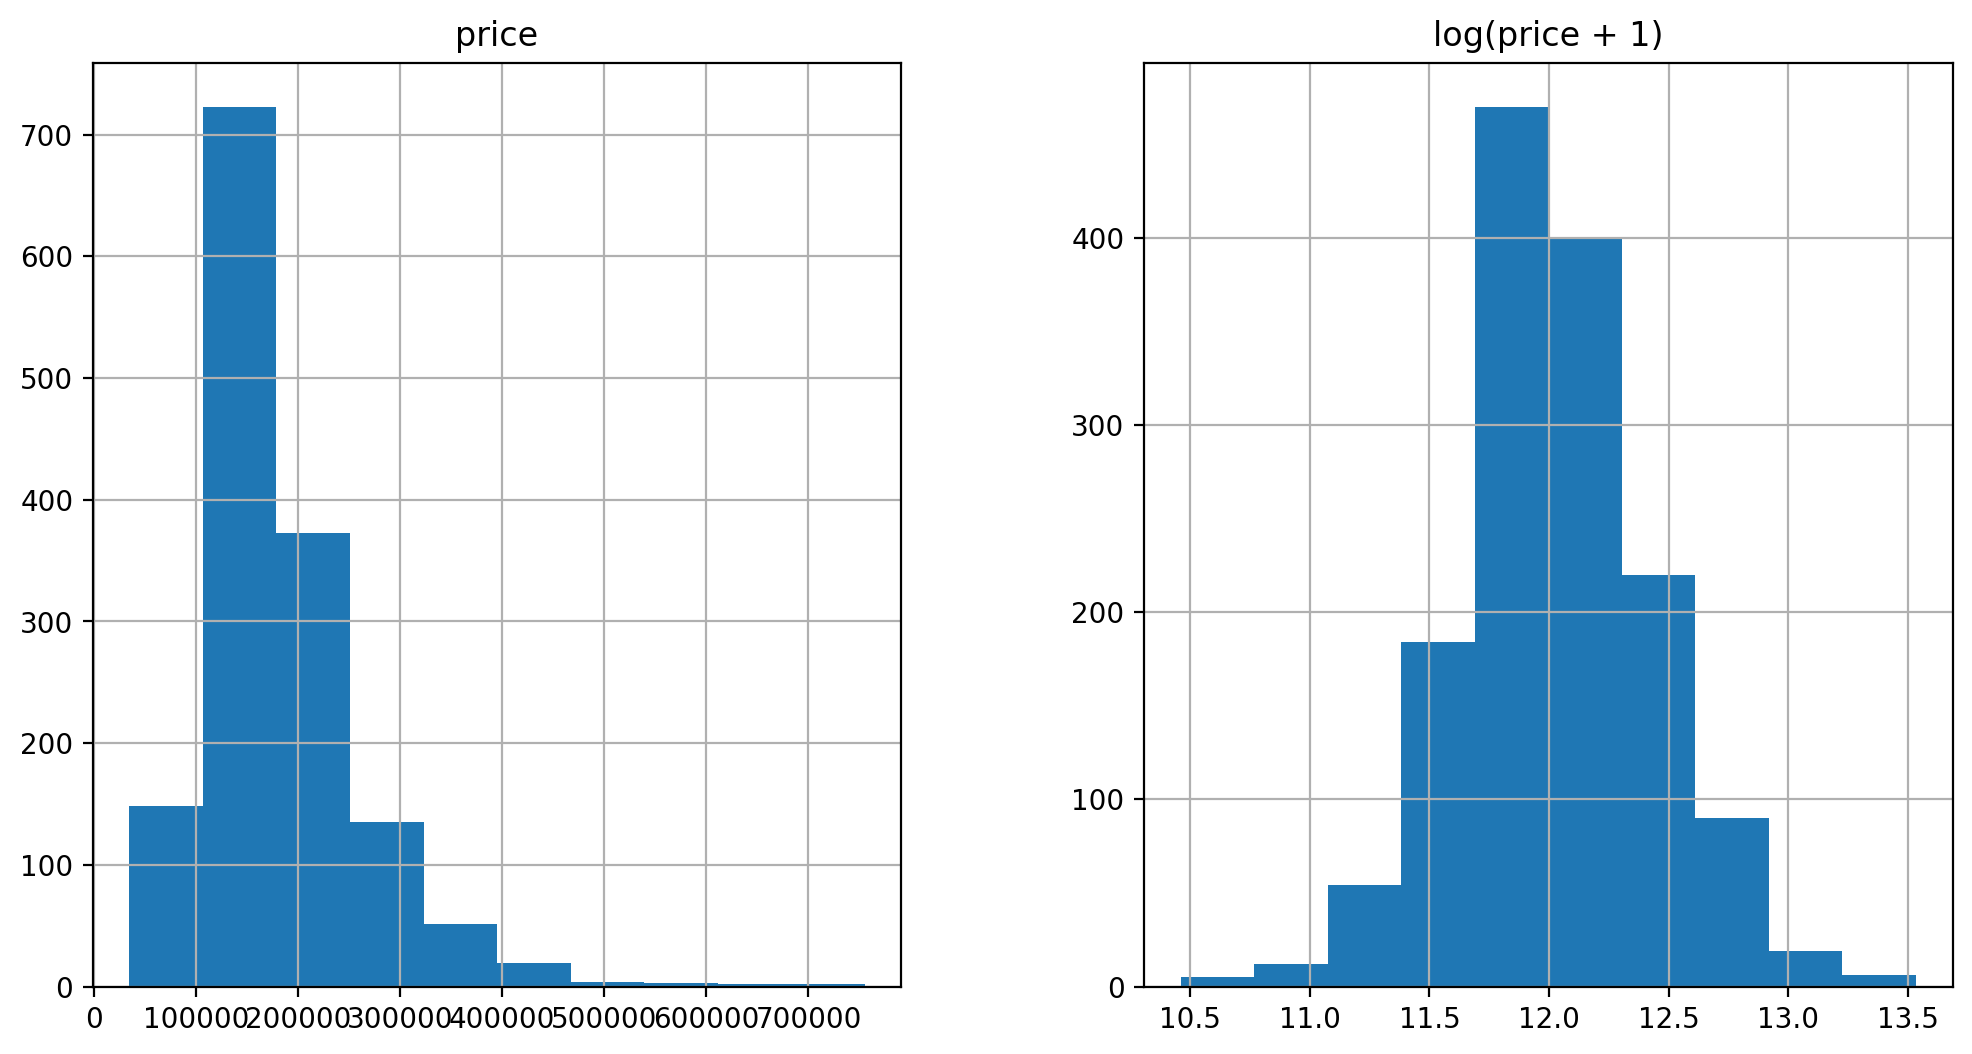

In [15]:
# remove skews by taking log(feature + 1)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [43]:
# unskew target
train['SalePrice'] = np.log1p(train['SalePrice'])

# transform skewed numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])


In [44]:
# create dummy vars for categorical variables
all_data = pd.get_dummies(all_data)

In [45]:
# fill na with column mean
all_data = all_data.fillna(all_data.mean()) # ask ta if we do this, kaggle guarded against it

In [46]:
# splt train data
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train['SalePrice']

In [21]:
# running ridge regression
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha=0.1)
model_ridge.fit(X_train, y)
y_pred = model_ridge.predict(X_test)
y_pred = np.expm1(y_pred)# exponentiate predictions
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_pred
})

submission.to_csv('ridge_submission.csv', index=False)
# received a rmse of 0.145

In [33]:
# running ridgecv
from sklearn.linear_model import RidgeCV, LassoCV
alphas = np.logspace(-3, 3, 400)

ridge_cv = RidgeCV(alphas=alphas, scoring='neg_root_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y)

# get best alpha
print("Best alpha for RidgeCV:", ridge_cv.alpha_)

y_pred = ridge_cv.predict(X_test)
y_pred = np.expm1(y_pred)
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_pred
})

submission.to_csv('ridgecv_submission.csv', index=False)
# received a rmse of 0.14192

Best alpha for RidgeCV: 15.0


In [47]:
# running lassocv

alphas = np.logspace(-3, 3, 400)
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y)

# get best alpha
print("Best alpha for LassoCV:", lasso_cv.alpha_)

y_pred = lasso_cv.predict(X_test)
y_pred = np.expm1(y_pred)
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_pred
})

submission.to_csv('lassocv_submission.csv', index=False)
# received a rmse of 0.13389

Best alpha for LassoCV: 0.001


<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
/var/folders/8c/mqvx3lqn6m513h1007r856ch0000gn/T/ipykernel_26652/3615470097.py:14: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$ Value')
/var/folders/8c/mqvx3lqn6m513h1007r856ch0000gn/T/ipykernel_26652/3615470097.py:16: SyntaxWarning: invalid escape sequence '\l'
  plt.title('L0 Norm vs Regularization Strength ($\lambda$)')
/Users/suprita/Desktop/data lab/Lab 3/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.095e+00, tolerance: 2.328e-02
  model = cd_fast.enet_coordinate_descent(
/Users/suprita/Desktop/data lab/Lab 3/.venv/lib/python3.12/site-pa

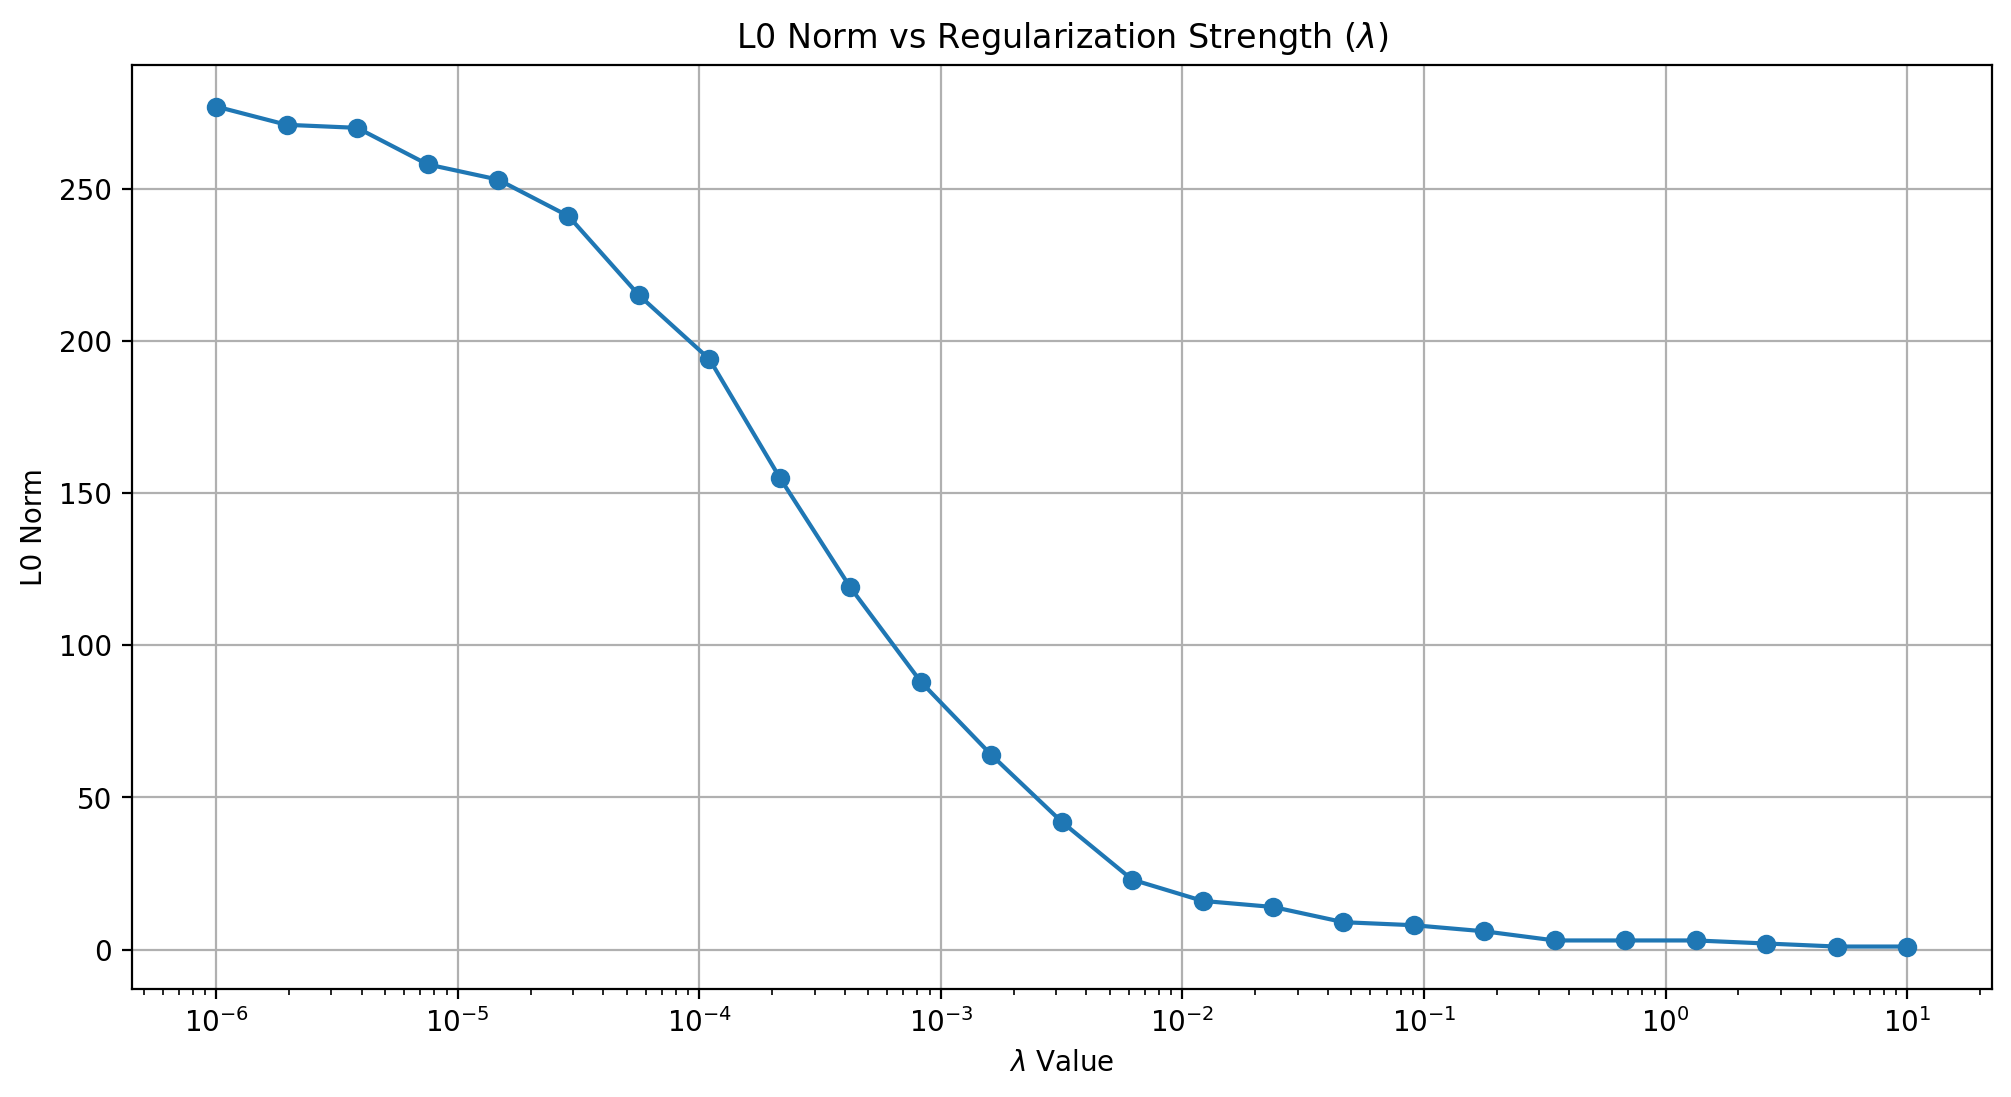

In [77]:
# part 4
from sklearn.linear_model import Lasso

# norm = number of nonzero coefficients
alphas = np.logspace(-6, 1, 25)
norms = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y)
    non_zero_coefficients = lasso.coef_[lasso.coef_ != 0]
    norms.append(len(non_zero_coefficients))
plt.plot(alphas, norms, marker='o')
plt.xscale('log')
plt.xlabel('$\lambda$ Value')
plt.ylabel('L0 Norm')
plt.title('L0 Norm vs Regularization Strength ($\lambda$)')
plt.grid(True)
plt.show()


In [84]:
# add model outputs as features
# train ridge regression on features including model outputs

# get model outputs
ridge_preds = ridge_cv.predict(X_train)
lasso_preds = lasso_cv.predict(X_train)

# add predictions to features using np.column_stack (stack train)
X_train_ensembled = np.column_stack([X_train, ridge_preds, lasso_preds])

# stack test
ridge_preds_test = ridge_cv.predict(X_test)
lasso_preds_test = lasso_cv.predict(X_test)
X_test_ensembled = np.column_stack([X_test, ridge_preds_test, lasso_preds_test])

# train new ridge model
ensembled= Ridge(alpha=15)
ensembled.fit(X_train_ensembled, y)

# predict on test set
y_preds = ensembled.predict(X_test_ensembled)
y_preds = np.expm1(y_preds)

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_preds
})

submission.to_csv('ensembled_submission.csv', index=False)
# got a rmse of 0.125, best one yet

In [85]:
# gonna add ElasticNet to see if it decreases loss even more
from sklearn.linear_model import ElasticNetCV

# hyperparams
alphas = np.logspace(-4, 0, 50)
l1_ratios = np.linspace(0.1, 1, 10)

# build and fit model
elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
elastic_cv.fit(X_train, y)

# get outputs
elastic_preds = elastic_cv.predict(X_train)
elastic_preds_test = elastic_cv.predict(X_test)

# stack
X_train_ensembled_elastic = np.column_stack([X_train, ridge_preds, lasso_preds, elastic_preds])
X_test_ensembled_elastic = np.column_stack([X_test, ridge_preds_test, lasso_preds_test, elastic_preds_test])

ensembled_elastic = Ridge(alpha=15)
ensembled_elastic.fit(X_train_ensembled_elastic, y)

# predict on test set
y_preds = ensembled_elastic.predict(X_test_ensembled_elastic)
y_preds = np.expm1(y_preds)

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_preds
})

submission.to_csv('ensembled_elastic_submission.csv', index=False)
# final score

/Users/suprita/Desktop/data lab/Lab 3/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06950184282163718, tolerance: 0.018912592760396085
  model = cd_fast.enet_coordinate_descent_gram(
/Users/suprita/Desktop/data lab/Lab 3/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16176798015235327, tolerance: 0.018912592760396085
  model = cd_fast.enet_coordinate_descent_gram(
/Users/suprita/Desktop/data lab/Lab 3/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34743327699475923, tolerance: 0.018912592760396085
  model = cd_fast.enet_coordinate_des